In [16]:
import pandas as pd
import numpy as np
import math, copy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Data Resume

In [17]:
house_prices = pd.read_csv("data/house.csv")
house_prices

,bedroom_count,net_sqm,center_distance,metro_distance,floor,age,price
0,1,26.184098,1286.68,204.003817,22,67,96004.804557
1,1,34.866901,1855.25,186.980360,8,30,92473.722568
2,1,36.980709,692.09,111.224999,24,24,98112.519942
3,1,17.445723,1399.49,237.998760,1,66,92118.326874
4,1,52.587646,84.65,100.996400,20,3,98976.653176
...,...,...,...,...,...,...,...
4303,9,175.166533,1299.71,217.739012,2,5,102707.356224
4304,6,215.352151,1346.36,77.724676,14,5,99695.064992
4305,5,299.563972,1585.37,235.537881,3,5,93803.715617
4306,1,29.193907,1896.23,147.223827,4,2,92914.729126


In [4]:
house_prices.describe()

,bedroom_count,net_sqm,center_distance,metro_distance,floor,age,price
count,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000,4308.000000
mean,3.732823,118.941327,1090.544301,105.665358,9.397168,48.576834,95701.196185
std,2.476989,95.469802,555.325830,60.750825,7.517018,27.621465,3919.823988
min,1.000000,10.244518,11.800000,1.245338,1.000000,0.000000,86113.592974
25%,2.000000,52.240659,635.897500,56.156897,2.000000,25.000000,92934.251436
50%,3.000000,91.828201,1143.135000,101.388012,8.000000,48.000000,95337.792918
75%,5.000000,150.987591,1554.280000,148.481068,16.000000,72.000000,97980.675094
max,17.000000,750.971604,1999.840000,330.275317,24.000000,97.000000,118134.771190


In [18]:
def null_count(df):

    df_nulls = {'columns': [], 'qt_nulls': []}

    for column in df.columns:

        qt_nulls = df[column].isnull().sum()

        df_nulls['columns'].append(column)
        df_nulls['qt_nulls'].append(qt_nulls)
    
    return pd.DataFrame(df_nulls)

null_count(house_prices)

,columns,qt_nulls
0,bedroom_count,0
1,net_sqm,0
2,center_distance,0
3,metro_distance,0
4,floor,0
5,age,0
6,price,0


Text(0.5, 1.0, 'Scatter : Price Houses')

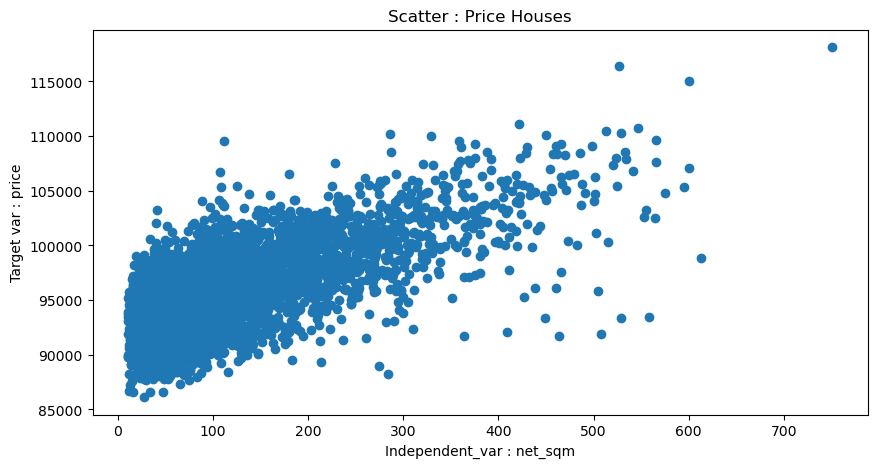

In [19]:
plt.figure(figsize=(10, 5))
plt.scatter(house_prices['net_sqm'], house_prices['price'])
plt.xlabel('Independent_var : net_sqm')
plt.ylabel('Target var : price')
plt.title('Scatter : Price Houses')

# Data Normalization

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(house_prices), columns=house_prices.columns)

# Modeling - Manual Linear Regression 

In [21]:
train, test = train_test_split(df_norm, test_size=0.3, random_state=98)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [22]:
x_train = train['net_sqm']
y_train = train['price']


x_test = test['net_sqm']
y_test = test['price']

## Computing Cost
Function MSE(Mean squared error) used to calculate how much the model is making mistakes according to the parameters sent.


The equation :
  $$J(w,b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})^2 \tag{1}$$
 
where 
  $$f_{w,b}(x^{(i)}) = wx^{(i)} + b \tag{2} = Linear Regression$$
  
- $f_{w,b}(x^{(i)})$ = prediction for example $i$ using parameters $w,b$.  
- $(f_{w,b}(x^{(i)}) -y^{(i)})^2$ = the squared difference between the target value and the prediction.   
- These differences are summed over all the $m$ examples and divided by `2m` to produce the cost, $J(w,b)$.
- The original equation was divided by $1/m$, however, by convention $1/2m$ was defined to facilitate the gradient calculation. 

In [23]:
def cost_function (x,y,w,b):

    # x = independent var
    # y = target var
    # w = function parameter of x (Define how much x increases or decreases for each unit of y)
    # b = function parameter (Define where the function will cross the y-axis)

    m= x.shape[0]
    cost = 0

    for i in range(m):
        #Linear Regression definition
        f_wb = w * x[i] + b 

        #Calculating the cost for record [i], plus the sum of the costs from previous records.
        cost = cost + (f_wb - y[i]) ** 2
    
    #After calculating the cost for all the records, we can determine the total cost of our function.
    total_cost = 1/ (2*m) * cost

    return total_cost

## Linear Regression Optimization : Gradient descent

After we have determined a way to measure how much the model's errors are influenced by parameters, we need to find the optimal values for these parameters to minimize the overall cost of the model.
The Gradient Descent has these function.
#
**Gradient Descent Functions**:
#
1. **Calculate the Gradiente for all parameters (calculate_gradient)**: Basically, the gradient are the partial derivate of the cost in relationship of parameter. The global cost minimum are when the partial derivate is equal or very close to 0.
#
Calculating for w and b :

$$
\begin{align}
\frac{\partial J(w,b)}{\partial w}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})x^{(i)} \\\
  \frac{\partial J(w,b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) \tag{5}\\
\end{align}
$$

3. **Measure the errors (cost_function)** : Measure the errors from parameters

3. **Gradient Descent - Updating the parameters for minimize de Cost Function (gradient_descent)** : Based on learning rate (alpha), we multiply the parameter gradient by this rate, after which the parameter is subtracted from this value. Thats is, when de gradient is zero, the cost function is minimized.

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline
\;  w &= w -  \alpha \frac{\partial J(w,b)}{\partial w} \tag{3}  \; \newline 
 b &= b -  \alpha \frac{\partial J(w,b)}{\partial b}  \newline \rbrace
\end{align*}$$


<figure>
     <center><img src="imgs/gradient.png"  style="width:400px;height:200px;"></center>
</figure>

In [24]:
def calculate_gradient (x, y, w, b):

    #Data examples
    m = x.shape[0]

    #The gradient of the cost w.r.t the parameters w
    dj_dw = 0

    #The gradient of the cost w.r.t the parameters b
    dj_db = 0

    
    for i in range(m):

        #Linear Regression function 
        f_wb = w * x[i] + b

        #Calculation of partial derivate of w cost.
        dj_dw_i = (f_wb - y[i]) * x[i]

        #Calculation of partial derivate of b cost.
        dj_db_i = f_wb - y[i]

        #Sum of derivates
        dj_dw += dj_dw_i
        dj_db += dj_db_i
    
    #Average of Derivates
    dj_dw = dj_dw / m
    dj_db = dj_db / m

    return dj_dw, dj_db

In [25]:
def gradient_descent (x, y, w_in, b_in, alpha, num_iters, cost_function, calculate_gradient):

    J_history =[]
    p_history = []


    #Initial parameters
    b = b_in
    w = w_in

    for i in range(num_iters):

        #Calculate the gradient
        dj_dw, dj_db = calculate_gradient(x,y,w,b)

        #Update parameters by alpha term * derivate of last iteration
        b = b - alpha * dj_db
        w = w - alpha * dj_dw

        #Save cost J at each iteration, and also the parameters
        if i<100000 : #prevent resourse exaustion

            J_history.append(cost_function(x,y,w,b))
            p_history.append([w,b])
        
        #Print cost every at intervals 10 times *Obs : math.ceil = function that rounds a number up to the nearest integer
        if i% math.ceil(num_iters/10) == 0:
            print(f"Iteration {i:4}: Cost {J_history[-1]:0.2e} ",
                  f"dj_dw: {dj_dw: 0.3e}, dj_db: {dj_db: 0.3e}  ",
                  f"w: {w: 0.3e}, b:{b: 0.5e}")
    
    #return w and J,w history for graphing
    return w, b, J_history, p_history

# Run Model

In [69]:
#Initialize parameters
w_init = 0
b_init = 0

#Gradient Descent settings
iterations = 10000
tmp_alpha = 1.0e-1

#Run the model
w_final, b_final, J_hist, p_hist = gradient_descent(x_train, y_train, w_init, b_init, tmp_alpha, iterations, cost_function, calculate_gradient)

print(f"(w,b) found by gradient descent: ({w_final:8.4f}, {b_final:8.4f})")

Iteration    0: Cost 4.31e-02  dj_dw: -5.430e-02, dj_db: -2.981e-01   w:  5.430e-03, b: 2.98149e-02
Iteration 1000: Cost 4.13e-03  dj_dw: -1.901e-03, dj_db:  2.833e-04   w:  5.218e-01, b: 2.21959e-01
Iteration 2000: Cost 4.02e-03  dj_dw: -3.740e-04, dj_db:  5.571e-05   w:  6.157e-01, b: 2.07978e-01
Iteration 3000: Cost 4.02e-03  dj_dw: -7.356e-05, dj_db:  1.096e-05   w:  6.341e-01, b: 2.05228e-01
Iteration 4000: Cost 4.02e-03  dj_dw: -1.447e-05, dj_db:  2.155e-06   w:  6.378e-01, b: 2.04687e-01
Iteration 5000: Cost 4.02e-03  dj_dw: -2.846e-06, dj_db:  4.239e-07   w:  6.385e-01, b: 2.04581e-01
Iteration 6000: Cost 4.02e-03  dj_dw: -5.597e-07, dj_db:  8.338e-08   w:  6.386e-01, b: 2.04560e-01
Iteration 7000: Cost 4.02e-03  dj_dw: -1.101e-07, dj_db:  1.640e-08   w:  6.386e-01, b: 2.04556e-01
Iteration 8000: Cost 4.02e-03  dj_dw: -2.165e-08, dj_db:  3.225e-09   w:  6.386e-01, b: 2.04555e-01
Iteration 9000: Cost 4.02e-03  dj_dw: -4.259e-09, dj_db:  6.344e-10   w:  6.386e-01, b: 2.04555e-01


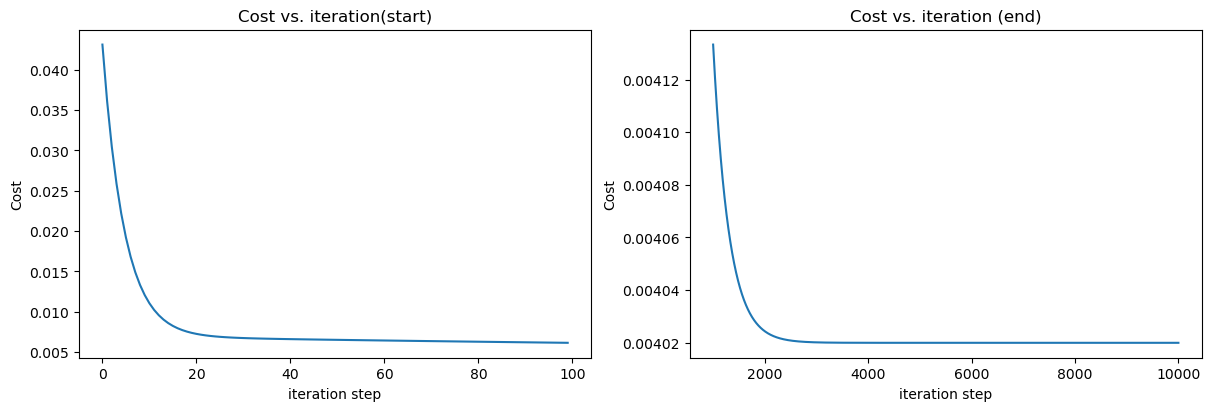

In [70]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))
ax1.plot(J_hist[:100])
ax2.plot(1000 + np.arange(len(J_hist[1000:])), J_hist[1000:])
ax1.set_title("Cost vs. iteration(start)");  ax2.set_title("Cost vs. iteration (end)")
ax1.set_ylabel('Cost')            ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')  ;  ax2.set_xlabel('iteration step')
plt.show()

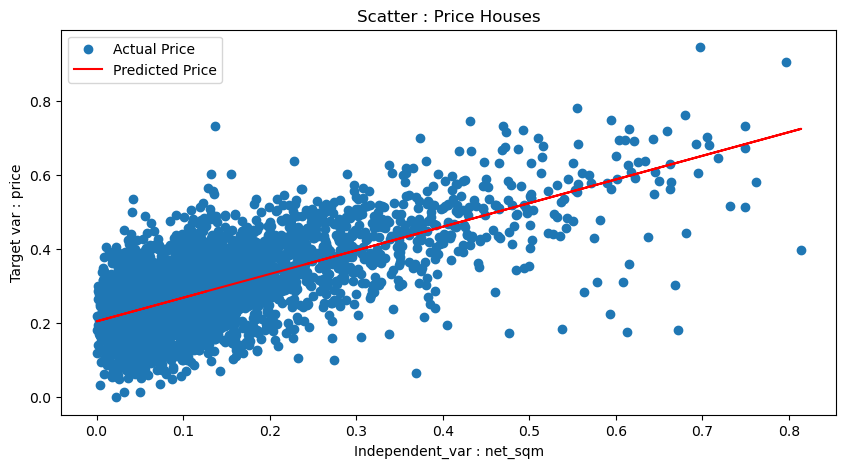

In [71]:
plt.figure(figsize=(10, 5))
plt.scatter(x_train, y_train, label = 'Actual Price')
plt.plot(x_train, w_final * x_train + b_final, color = 'red', label = 'Predicted Price')
plt.xlabel('Independent_var : net_sqm')
plt.ylabel('Target var : price')
plt.title('Scatter : Price Houses')
plt.legend()
plt.show()

# Model Validation

In [107]:
y_pred = w_final * x_test + b_final

mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)

rmse = mean_squared_error(y_test, y_pred, squared=False)

r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

Mean Absolute Error (MAE): 0.0711200253206746
Mean Squared Error (MSE): 0.007961037397862459
Root Mean Squared Error (RMSE): 0.0892246456863935
R-squared (R²): 0.48187085735815494


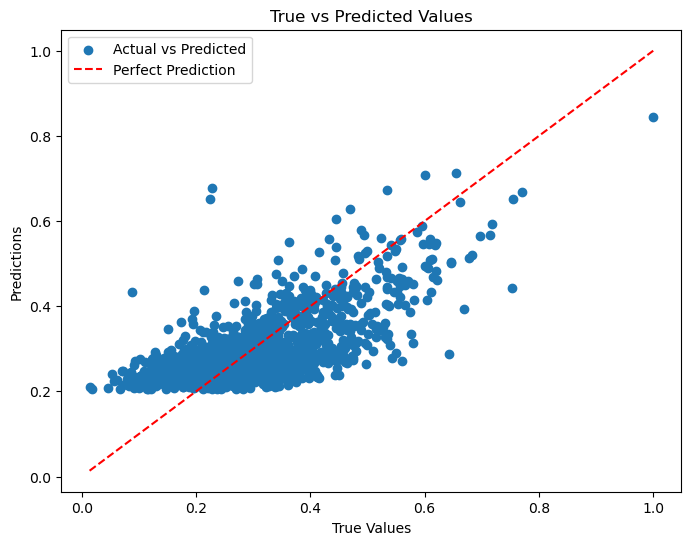

In [108]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, label='Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

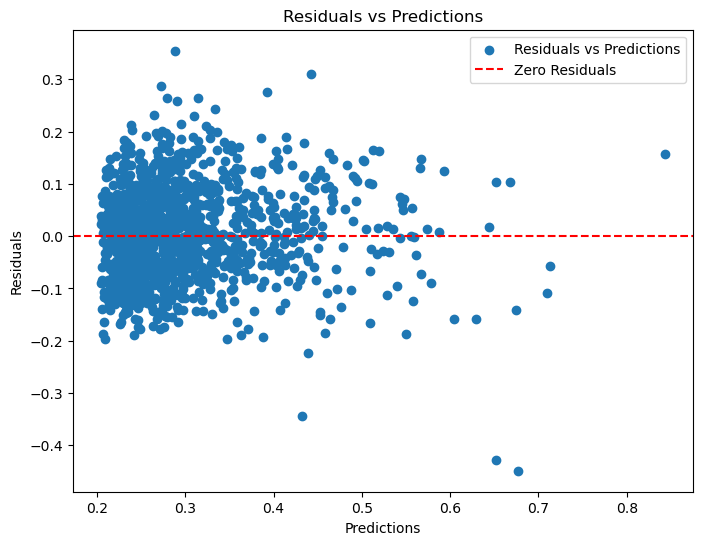

In [109]:
residuos = y_test - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuos, label='Residuals vs Predictions')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residuals')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residuals vs Predictions')
plt.legend()
plt.show()

# Modeling - Sklearn Linear Regression

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

In [76]:
x_train_reshape = np.array(x_train).reshape(-1, 1)
y_train_reshape = np.array(y_train).reshape(-1, 1)

x_test_reshape = np.array(x_test).reshape(-1, 1)
y_test_reshape = np.array(y_test).reshape(-1, 1)

# Sklearn Linear Regression : Normal Equation

In [77]:
lr_normal = LinearRegression()
lr_normal.fit(x_train_reshape, y_train_reshape)

y_pred_train = lr_normal.predict(x_train_reshape)

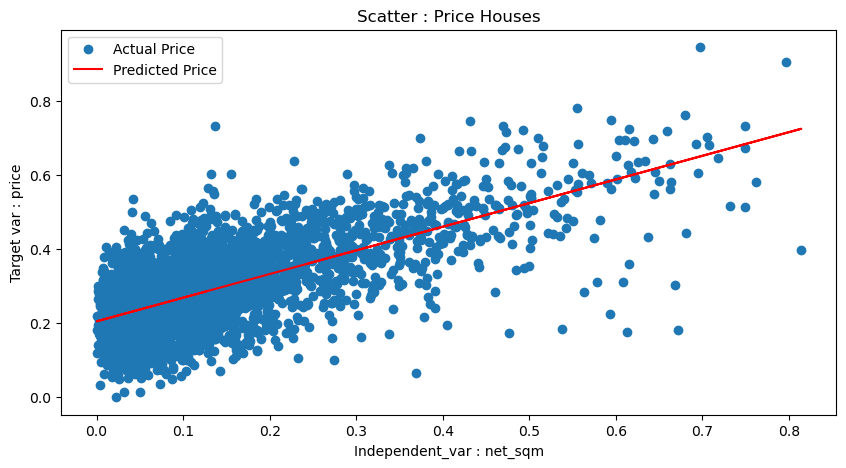

In [78]:
plt.figure(figsize=(10, 5))
plt.scatter(x_train_reshape, y_train_reshape, label = 'Actual Price')
plt.plot(x_train_reshape, y_pred_train, color = 'red', label = 'Predicted Price')
plt.xlabel('Independent_var : net_sqm')
plt.ylabel('Target var : price')
plt.title('Scatter : Price Houses')
plt.legend()
plt.show()

In [96]:
y_pred_test_re = lr_normal.predict(x_test_reshape)

mae = mean_absolute_error(y_test_reshape, y_pred_test_re)

mse = mean_squared_error(y_test_reshape, y_pred_test_re)

rmse = mean_squared_error(y_test_reshape, y_pred_test_re, squared=False)

r2 = r2_score(y_test_reshape, y_pred_test_re)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

Mean Absolute Error (MAE): 0.07112002493242835
Mean Squared Error (MSE): 0.007961037346906315
Root Mean Squared Error (RMSE): 0.0892246454008438
R-squared (R²): 0.48187086067453966


# Sklearn Linear Regression : Gradient Descent

In [102]:
sgd_model = SGDRegressor(loss='squared_error', alpha=1.0e-3, learning_rate='optimal', max_iter=10000, epsilon=0.1)

sgd_model.fit(x_train_reshape, y_train)
y_pred_sgd = sgd_model.predict(x_train_reshape)

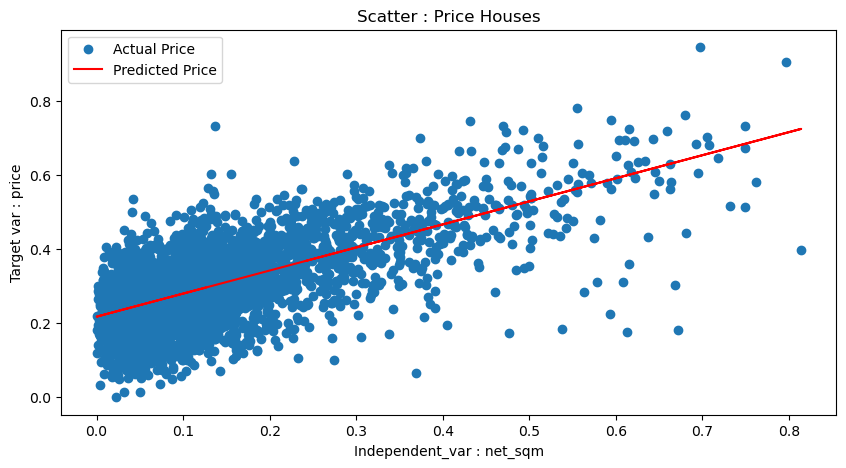

In [103]:
plt.figure(figsize=(10, 5))
plt.scatter(x_train_reshape, y_train_reshape, label = 'Actual Price')
plt.plot(x_train_reshape, y_pred_sgd, color = 'red', label = 'Predicted Price')
plt.xlabel('Independent_var : net_sqm')
plt.ylabel('Target var : price')
plt.title('Scatter : Price Houses')
plt.legend()
plt.show()

In [105]:
y_pred_test_sgd = sgd_model.predict(x_test_reshape)

mae = mean_absolute_error(y_test_reshape, y_pred_test_sgd)

mse = mean_squared_error(y_test_reshape, y_pred_test_sgd)

rmse = mean_squared_error(y_test_reshape, y_pred_test_sgd, squared=False)

r2 = r2_score(y_test_reshape, y_pred_test_sgd)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

Mean Absolute Error (MAE): 0.0714510870032555
Mean Squared Error (MSE): 0.008009212850969154
Root Mean Squared Error (RMSE): 0.08949420568377126
R-squared (R²): 0.47873544862093964


# Models Comparations

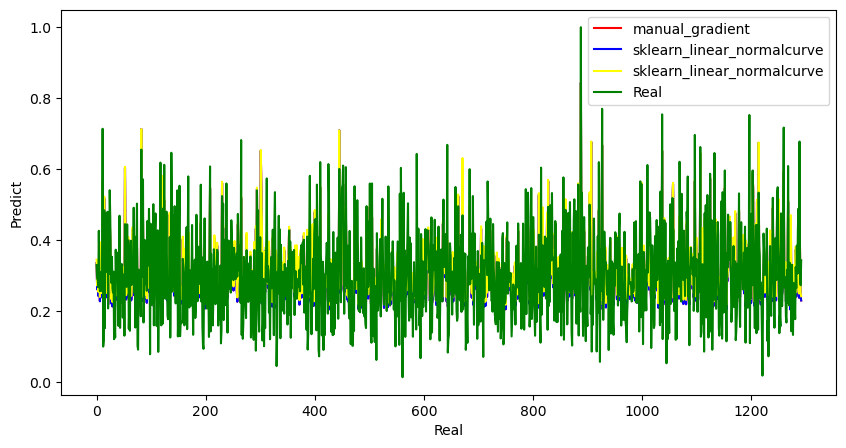

In [110]:
plt.figure(figsize=(10,5))
plt.plot(y_pred, color='red', label='manual_gradient')
plt.plot(y_pred_test_re, color='blue', label='sklearn_linear_normalcurve')
plt.plot(y_pred_test_sgd, color='yellow', label='sklearn_linear_normalcurve')
plt.plot(y_test, color='green', label='Real')
plt.xlabel('Real')
plt.ylabel('Predict')
plt.legend()
plt.show()